# Advanced_ML: Домашнее задание 2

Background: в спортивном “Что? Где? Когда?” соревнующиеся команды отвечают на одни и те
же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на
карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из
нескольких десятков вопросов (обычно 36 или 45, иногда 60, больше редко). Часто бывают
синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых
площадок по всему миру, т.е. в одном турнире могут играть сотни, а то и тысячи команд.

Соответственно, нам нужно:

● построить рейтинг-лист, который способен нетривиально предсказывать результаты
будущих турниров;

● при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно
переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за
другую команду и т.д.; поэтому единицей рейтинг-листа должна быть не команда, а
отдельный игрок;

● а что сильно упрощает задачу и переводит её в область домашних заданий на
EM-алгоритм — это характер данных: начиная с какого-то момента, в базу результатов
начали вносить все повопросные результаты команд, т.е.

Я сделал за вас только первый шаг: выкачал через API сайта рейтинга ЧГК все нужные данные,
чтобы сайт не прилёг под вашими многочисленными скрейперами. :) Полученные данные лежат
в формате pickle

## 1. Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). 
Для унификации предлагаю:

○ взять в тренировочный набор турниры с dateStart из 2019 года;

○ в тестовый — турниры с dateStart из 2020 года.

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score, accuracy_score

from scipy.stats.stats import spearmanr
from scipy.stats.stats import kendalltau
from scipy.sparse import lil_matrix, csr_matrix, coo_matrix, hstack, save_npz, load_npz


import warnings
warnings.filterwarnings("ignore")

In [2]:
tournaments = pickle.load(open("chgk/tournaments.pkl", "rb"))
results = pickle.load(open("chgk/results.pkl", "rb"))
players = pickle.load(open("chgk/players.pkl", "rb"))

Let's look at the data samples:

In [3]:
tournaments[3]

{'id': 3,
 'name': 'Турнир в Ижевске',
 'dateStart': '2003-11-22T00:00:00+03:00',
 'dateEnd': '2003-11-24T00:00:00+03:00',
 'type': {'id': 2, 'name': 'Обычный'},
 'season': '/seasons/2',
 'orgcommittee': [],
 'synchData': None,
 'questionQty': None}

In [4]:
tournaments[601]

{'id': 601,
 'name': 'Кубок губернатора Мурманской области',
 'dateStart': '2010-03-21T00:00:00+03:00',
 'dateEnd': '2010-03-21T00:00:00+03:00',
 'type': {'id': 2, 'name': 'Обычный'},
 'season': '/seasons/9',
 'orgcommittee': [],
 'synchData': None,
 'questionQty': None}

In [5]:
results[2][:3]

[{'team': {'id': 312,
   'name': 'Социал-демократы',
   'town': {'id': 201, 'name': 'Москва'}},
  'mask': None,
  'current': {'name': 'Социал-демократы',
   'town': {'id': 201, 'name': 'Москва'}},
  'questionsTotal': 0,
  'synchRequest': None,
  'position': 1,
  'controversials': [],
  'flags': [],
  'teamMembers': []},
 {'team': {'id': 510,
   'name': 'Импульс',
   'town': {'id': 286, 'name': 'Саранск'}},
  'mask': None,
  'current': {'name': 'Импульс', 'town': {'id': 286, 'name': 'Саранск'}},
  'questionsTotal': 0,
  'synchRequest': None,
  'position': 2,
  'controversials': [],
  'flags': [],
  'teamMembers': [{'flag': None,
    'usedRating': 0,
    'rating': 0,
    'player': {'id': 33199,
     'name': 'Михаил',
     'patronymic': 'Николаевич',
     'surname': 'Филаткин'}},
   {'flag': None,
    'usedRating': 0,
    'rating': 0,
    'player': {'id': 29333,
     'name': 'Михаил',
     'patronymic': 'Игоревич',
     'surname': 'Скипский'}},
   {'flag': None,
    'usedRating': 0,
    '

In [6]:
players[1]

{'id': 1, 'name': 'Алексей', 'patronymic': None, 'surname': 'Абабилов'}

In [7]:
train_tournaments = []
test_tournaments = []

for t_num in tournaments:
    if (tournaments[t_num]['dateStart'] >= '2019-01-01') and \
       (tournaments[t_num]['dateStart'] < '2020-01-01'):
        
        train_tournaments.append(tournaments[t_num])
        
        
for t_num in tournaments:
    if (tournaments[t_num]['dateStart'] >= '2020-01-01') and \
       (tournaments[t_num]['dateStart'] < '2021-01-01'):
        
        test_tournaments.append(tournaments[t_num])

print(f'train_tournaments: {len(train_tournaments)}')
print(f'test_tournaments: {len(test_tournaments)}')

train_tournaments: 687
test_tournaments: 418


In [8]:
train_tournaments[0]

{'id': 4772,
 'name': 'Синхрон северных стран. Зимний выпуск',
 'dateStart': '2019-01-05T19:00:00+03:00',
 'dateEnd': '2019-01-09T19:00:00+03:00',
 'type': {'id': 3, 'name': 'Синхрон'},
 'season': '/seasons/52',
 'orgcommittee': [{'id': 28379,
   'name': 'Константин',
   'patronymic': 'Владимирович',
   'surname': 'Сахаров'}],
 'synchData': {'dateRequestsAllowedTo': '2019-01-09T23:59:59+03:00',
  'resultFixesTo': '2019-01-19T23:59:59+03:00',
  'resultsRecapsTo': '2019-01-11T23:59:59+03:00',
  'allowAppealCancel': True,
  'allowNarratorErrorAppeal': False,
  'dateArchivedAt': '2019-01-26T23:59:59+03:00',
  'dateDownloadQuestionsFrom': '2019-01-04T00:00:00+03:00',
  'dateDownloadQuestionsTo': '2019-01-09T19:00:00+03:00',
  'hideQuestionsTo': '2019-01-09T23:59:59+03:00',
  'hideResultsTo': '2019-01-09T23:59:59+03:00',
  'allVerdictsDone': None,
  'instantControversial': True},
 'questionQty': {'1': 12, '2': 12, '3': 12}}

In [9]:
results[4772][:2]

[{'team': {'id': 45556,
   'name': 'Рабочее название',
   'town': {'id': 285, 'name': 'Санкт-Петербург'}},
  'mask': '111111111011111110111111111100010010',
  'current': {'name': 'Рабочее название',
   'town': {'id': 285, 'name': 'Санкт-Петербург'}},
  'questionsTotal': 28,
  'synchRequest': {'id': 56392,
   'venue': {'id': 3030, 'name': 'Санкт-Петербург'}},
  'position': 1,
  'controversials': [{'id': 91169,
    'questionNumber': 15,
    'answer': 'Мьёльнир',
    'issuedAt': '2019-01-06T13:28:48+03:00',
    'status': 'A',
    'comment': '',
    'resolvedAt': '2019-01-06T15:25:54+03:00',
    'appealJuryComment': None}],
  'flags': [],
  'teamMembers': [{'flag': 'Б',
    'usedRating': 13507,
    'rating': 13507,
    'player': {'id': 6212,
     'name': 'Юрий',
     'patronymic': 'Яковлевич',
     'surname': 'Выменец'}},
   {'flag': 'Б',
    'usedRating': 10988,
    'rating': 13185,
    'player': {'id': 18332,
     'name': 'Александр',
     'patronymic': 'Витальевич',
     'surname': 'Либ

In [10]:
train_idx = [tournament_info['id'] for tournament_info in train_tournaments]
test_idx = [tournament_info['id'] for tournament_info in test_tournaments]

len(train_idx), len(test_idx)

(687, 418)

There are question mask values: '1' - question is answered correctly, '0' - not correctly. Values 'X' and '?' refer to controversial questions and I decided to exclude them.

In [11]:
def get_player_name(player_info):
    if player_info['patronymic']:
        name = f"{player_info['surname']} {player_info['name']} {player_info['patronymic']}"
        
    else:
        name = f"{player_info['surname']} {player_info['name']}"
        
    return name


def get_dataset(data_idx, results=results, tournaments=tournaments):
    
    tournament_teams = defaultdict(list)

    dataset = {
        'player_id': [],
        'player_name': [],
        'player_rating': [],
        'team_id': [],
        'team_position': [],
        'tournament_id': [],
        'tournament_name': [],
        'question_id': [],
        'is_answered': [],
    }

    for idx in data_idx:
        one_result = results[idx]

        for command_info in one_result:
            player_id_list = []
            
            try:
                n_team_members = len(command_info['teamMembers'])
                result_mask = command_info['mask']
                
                if result_mask is None:
                    continue

                if 'X' in result_mask or '?' in result_mask:
                    continue
                
                if n_team_members > 0:
                    
                    for player in command_info['teamMembers']:
                        player_id_list.append(player['player']['id'])
                        
                        for q_num, is_answered in enumerate(result_mask):

                                p_info = player['player']
                                p_full_name = get_player_name(p_info)
                                
                                dataset['player_id'].append(p_info['id'])
                                dataset['player_name'].append(p_full_name)
                                dataset['player_rating'].append(player['rating'])

                                dataset['team_id'].append(command_info['team']['id'])
                                dataset['team_position'].append(command_info['position'])

                                dataset['tournament_id'].append(idx)
                                dataset['tournament_name'].append(tournaments[idx]['name'])

                                dataset['is_answered'].append(int(is_answered))
                                dataset['question_id'].append(f'{idx}_{q_num}')
            
                if len(player_id_list) > 0:
                    tournament_teams[idx].append({'team_id': command_info['team']['id'],
                                                  'player_id_list': player_id_list,
                                                  'team_position': command_info['position']})

                                
            except IndexError as e:
                continue
            except KeyError as e:
                continue
                
    dataset = pd.DataFrame(dataset)
    
    return dataset, tournament_teams

In [12]:
train, tournament_teams_train = get_dataset(train_idx)
test, tournament_teams_test = get_dataset(test_idx)

train.shape, test.shape

((17295090, 9), (3974507, 9))

In [13]:
train.head()

,player_id,player_name,player_rating,team_id,team_position,tournament_id,tournament_name,question_id,is_answered
0,6212,Выменец Юрий Яковлевич,13507,45556,1.0,4772,Синхрон северных стран. Зимний выпуск,4772_0,1
1,6212,Выменец Юрий Яковлевич,13507,45556,1.0,4772,Синхрон северных стран. Зимний выпуск,4772_1,1
2,6212,Выменец Юрий Яковлевич,13507,45556,1.0,4772,Синхрон северных стран. Зимний выпуск,4772_2,1
3,6212,Выменец Юрий Яковлевич,13507,45556,1.0,4772,Синхрон северных стран. Зимний выпуск,4772_3,1
4,6212,Выменец Юрий Яковлевич,13507,45556,1.0,4772,Синхрон северных стран. Зимний выпуск,4772_4,1


In [14]:
len(tournament_teams_train[4973])

1027

## 2. Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:

○ повопросные результаты — это фактически результаты броска монетки, и их
предсказание скорее всего имеет отношение к бинарной классификации;

○ в разных турнирах вопросы совсем разного уровня сложности, поэтому модель
должна это учитывать; скорее всего, модель должна будет явно обучать не только
силу каждого игрока, но и сложность каждого вопроса;

○ для baseline-модели можно забыть о командах и считать, что повопросные
результаты команды просто относятся к каждому из её игроков.

Let's evaluate how player is good and how questions are hard based on the means answers rates.

In [15]:
train_counts = Counter(train['is_answered'])
test_counts = Counter(test['is_answered'])
train_counts, test_counts

(Counter({1: 7421225, 0: 9873865}), Counter({1: 1830135, 0: 2144372}))

Classes are almost balanced with a little bit more questions answered incorrectly.

For baseline model I'll use Logistic Regression and dummy variables for every player $i$ and every question $q$ to evaluate a player's strength $s_i$ and question's complexity $c_q$.

Logistic Regression:

$$p(x_{tq} | s_i,c_q)\sim \sigma(\mu + s_i + c_q)$$

for each player $i \in t$ of a partisipating team and each question $q$, where $\sigma(x) = 1/(1+e^x)$ is the logistic sigmoid and $x_{tq}$ denotes whether team $t$ answered question $q$ correctly.

In [16]:
encoder_player = OneHotEncoder(dtype=int)
encoder_question = OneHotEncoder(dtype=int)

ohe_players = encoder_player.fit_transform(train['player_id'].values.reshape(-1,1))
ohe_questions = encoder_question.fit_transform(train['question_id'].values.reshape(-1,1))

X_train = hstack([ohe_players, ohe_questions])
X_train.shape

(17295090, 87809)

In [17]:
%%time
baseline = LogisticRegression(random_state=78)

baseline.fit(X_train, train.is_answered)
baseline.coef_[0]

CPU times: user 5min 48s, sys: 33.8 s, total: 6min 21s
Wall time: 2min 20s


array([ 0.6747372 ,  1.56185269,  0.4241    , ...,  0.58825246,
        0.49337729, -0.60860922])

## 3. Качество рейтинг-системы оценивается качеством предсказаний результатов турниров.
Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь
неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны
эти предсказания сами по себе. Поэтому:

○ предложите способ предсказать результаты нового турнира с известными
составами, но неизвестными вопросами, в виде ранжирования команд;

○ в качестве метрики качества на тестовом наборе давайте считать ранговые
корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между
реальным ранжированием в результатах турнира и предсказанным моделью,
усреднённые по тестовому множеству турниров1.

In [18]:
rating_dict = dict(zip(encoder_player.categories_[0], 
                       baseline.coef_[0][:len(encoder_player.categories_[0])]))

question_complexity_dict = dict(zip(encoder_question.categories_[0], 
                                    baseline.coef_[0][len(encoder_player.categories_[0]):]))

Players play games and their rating changes with every game. So the 'player rating' field changes too. For the rating list I decided to leave only maximum rating for the period.

In [19]:
id_rating_name = train[['player_id', 'player_rating', 'player_name']]

id_rating_name.sort_values(by='player_rating', ascending=False, inplace=True)
id_rating_name.drop_duplicates(subset='player_id', keep='first', inplace=True)
id_rating_name.reset_index(drop=True, inplace=True)
print(id_rating_name.shape)

id_rating_name.head()

(57288, 3)


,player_id,player_rating,player_name
0,30152,14897,Сорожкин Артём Сергеевич
1,28751,14789,Семушин Иван Николаевич
2,27822,14726,Савченков Михаил Владимирович
3,30270,14708,Спешков Сергей Леонидович
4,27403,14543,Руссо Максим Михайлович


In [20]:
# calculated player rating

id_rating_name['calculated_strength'] = id_rating_name['player_id'].apply(lambda x: 
                                                                          rating_dict[x])
calculated_rating = id_rating_name

calculated_rating.sort_values(by='calculated_strength', ascending=False, inplace=True)
calculated_rating.reset_index(drop=True, inplace=True)

calculated_rating.head(20)

,player_id,player_rating,player_name,calculated_strength
0,27403,14543,Руссо Максим Михайлович,3.754888
1,4270,14543,Брутер Александра Владимировна,3.752943
2,28751,14789,Семушин Иван Николаевич,3.595997
3,30152,14897,Сорожкин Артём Сергеевич,3.568486
4,27822,14726,Савченков Михаил Владимирович,3.478352
5,30260,9301,Спектор Евгений Павлович,3.463680
6,30270,14708,Спешков Сергей Леонидович,3.442100
7,87637,13162,Саксонов Антон Владимирович,3.402763
8,18036,13642,Левандовский Михаил Ильич,3.347925
9,21698,13081,Мосягин Александр Владимирович,3.303968


In [21]:
# true player rating
calculated_rating.sort_values(by='player_rating', ascending=False, inplace=True)
calculated_rating.reset_index(drop=True, inplace=True)

true_rating = calculated_rating.player_rating.values

calculated_rating.head(20)

,player_id,player_rating,player_name,calculated_strength
0,30152,14897,Сорожкин Артём Сергеевич,3.568486
1,28751,14789,Семушин Иван Николаевич,3.595997
2,27822,14726,Савченков Михаил Владимирович,3.478352
3,30270,14708,Спешков Сергей Леонидович,3.442100
4,27403,14543,Руссо Максим Михайлович,3.754888
5,4270,14543,Брутер Александра Владимировна,3.752943
6,18332,14464,Либер Александр Витальевич,3.229986
7,23737,14276,Островский Андрей Вячеславович,3.177739
8,33620,14151,Хаиткулов Руслан Гафурович,2.950364
9,6212,14083,Выменец Юрий Яковлевич,3.134901


In 2 ratings above you can see that the baseline model approximates the rating rather good. In actual rating top11 players are with 14000+ points whereas in the predicted rating there is even 1 player with 9k rating. This means the baseline model gives more poins for some lucky individuals who played not as much games but who was really successful thus the baseline model needs some improvement.

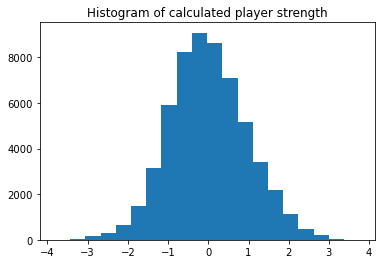

In [22]:
plt.title('Histogram of calculated player strength')
plt.hist(calculated_rating.calculated_strength, bins=20)
plt.show()

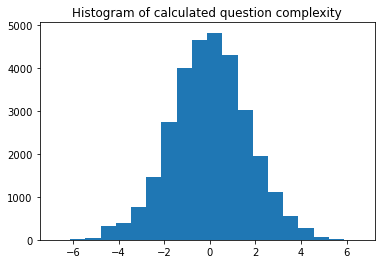

In [23]:
plt.title('Histogram of calculated question complexity')
plt.hist(list(question_complexity_dict.values()), bins=20)
plt.show()

In [24]:
train.head()

,player_id,player_name,player_rating,team_id,team_position,tournament_id,tournament_name,question_id,is_answered
0,6212,Выменец Юрий Яковлевич,13507,45556,1.0,4772,Синхрон северных стран. Зимний выпуск,4772_0,1
1,6212,Выменец Юрий Яковлевич,13507,45556,1.0,4772,Синхрон северных стран. Зимний выпуск,4772_1,1
2,6212,Выменец Юрий Яковлевич,13507,45556,1.0,4772,Синхрон северных стран. Зимний выпуск,4772_2,1
3,6212,Выменец Юрий Яковлевич,13507,45556,1.0,4772,Синхрон северных стран. Зимний выпуск,4772_3,1
4,6212,Выменец Юрий Яковлевич,13507,45556,1.0,4772,Синхрон северных стран. Зимний выпуск,4772_4,1


In [25]:
K_BEST_PLAYERS = 4

def get_ratings(team_list, k_best_players, rating_dict):
    team_id = []
    team_position = []
    team_score = []
    
    for team in team_list:
        team_results = [rating_dict[player] if player in rating_dict else 0 
                        for player in team['player_id_list']]
        team_results = team_results[:k_best_players]
        
        team_id.append(team['team_id'])
        team_position.append(team['team_position'])
        team_score.append(np.mean(team_results))
    
    data = pd.DataFrame(data={'team_id': team_id,
                              'team_position': team_position,
                              'team_score': team_score})
    
    data.sort_values(by='team_score', ascending=False, inplace=True)
    
    data['predicted_rating'] = range(data.shape[0])
    data.sort_values(by='team_position', ascending=True, inplace=True)
    
    true_rating = data['team_position'].values
    predicted_rating = data['predicted_rating'].values
    
    return predicted_rating, true_rating

In [26]:
def get_metrics(tournament_teams, k_best_players=K_BEST_PLAYERS, rating_dict=rating_dict):
    spearman_scores = []
    kendall_scores = []

    for tournament_id, team_list in tournament_teams.items():

        predicted_rating, true_rating = get_ratings(team_list, k_best_players, rating_dict)

        spearman_scores.append(spearmanr(predicted_rating, true_rating)[0])
        kendall_scores.append(kendalltau(predicted_rating, true_rating)[0])

    spearman_scores = [sp for sp in spearman_scores if not np.isnan(sp)]
    kendall_scores = [kd for kd in kendall_scores if not np.isnan(kd)]
    
    return np.mean(spearman_scores), np.mean(kendall_scores)

In [27]:
for k_best_players in range(1,7):
    print(f'Best_players: {k_best_players}')
    
    spearman_scores, kendall_scores = get_metrics(tournament_teams_train, k_best_players, rating_dict)
    print(f'Train: Spearman_score: {np.mean(spearman_scores)}, Kendall_scores: {np.mean(kendall_scores)}')
    
    spearman_scores, kendall_scores = get_metrics(tournament_teams_test, k_best_players, rating_dict)
    print(f'Test: Spearman_score: {np.mean(spearman_scores)}, Kendall_scores: {np.mean(kendall_scores)}\n')

Best_players: 1
Train: Spearman_score: 0.7784229772155338, Kendall_scores: 0.6224049202561804
Test: Spearman_score: 0.7333005097063422, Kendall_scores: 0.5746716838007282

Best_players: 2
Train: Spearman_score: 0.8076941014334738, Kendall_scores: 0.6530297640922516
Test: Spearman_score: 0.7616653580128055, Kendall_scores: 0.6023231210598669

Best_players: 3
Train: Spearman_score: 0.8188570429247038, Kendall_scores: 0.6664519822764452
Test: Spearman_score: 0.7661573565827577, Kendall_scores: 0.6076443437555108

Best_players: 4
Train: Spearman_score: 0.8261942612402351, Kendall_scores: 0.6756245588368821
Test: Spearman_score: 0.7675797495147385, Kendall_scores: 0.6122145129388065

Best_players: 5
Train: Spearman_score: 0.827598053730591, Kendall_scores: 0.6777933275803605
Test: Spearman_score: 0.7641293637414556, Kendall_scores: 0.6088314882618354

Best_players: 6
Train: Spearman_score: 0.8296363091000967, Kendall_scores: 0.6809930573701285
Test: Spearman_score: 0.7590796848103327, Kenda

In [28]:
# the best baseline result
K_BEST_PLAYERS = 4

spearman_scores, kendall_scores = get_metrics(tournament_teams_train, K_BEST_PLAYERS, rating_dict)
print(f'Train: Spearman_score: {np.mean(spearman_scores)}, Kendall_scores: {np.mean(kendall_scores)}')
    
spearman_scores, kendall_scores = get_metrics(tournament_teams_test, K_BEST_PLAYERS, rating_dict)
print(f'Test: Spearman_score: {np.mean(spearman_scores)}, Kendall_scores: {np.mean(kendall_scores)}\n')

Train: Spearman_score: 0.8261942612402351, Kendall_scores: 0.6756245588368821
Test: Spearman_score: 0.7675797495147385, Kendall_scores: 0.6122145129388065



I have found that even though a team is up to 6 persons, better approximation of the team strength is the average of team's 4 most skillful players. I'll use this later to evaluate other models.

## 4. Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:

○ предложите способ учитывать то, что на вопрос отвечают сразу несколько
игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать
упрощающие предположения, но теперь переменные “игрок X ответил на вопрос
Y” при условии данных должны стать зависимыми для игроков одной и той же
команды;

○ разработайте EM-схему для обучения этой модели, реализуйте её в коде;

○ обучите несколько итераций, убедитесь, что целевые метрики со временем
растут (скорее всего, ненамного, но расти должны), выберите лучшую модель,
используя целевые метрики.

In [29]:
dataset_for_em = train[['team_id', 'player_id', 'question_id', 'is_answered']]
print(dataset_for_em.shape)

dataset_for_em.head()

(17295090, 4)


,team_id,player_id,question_id,is_answered
0,45556,6212,4772_0,1
1,45556,6212,4772_1,1
2,45556,6212,4772_2,1
3,45556,6212,4772_3,1
4,45556,6212,4772_4,1


For each player-question pair, we add a latent variable $z_{iq}$ which means "player $i$ has answered question $q$". I formed them according to the rule: 


* if $x_{tq}=0$ then $z_{iq}=0$ for every player $i \in t$
* if $x_{tq}=1$ then $z_{iq}=1$ for at least one player $i \in t$

### EM algorithm will look like:


E step: fix all $s_i$ and $c_q$, compute expected values of latent valiables $z_{iq}$
$$
\mathbb{E}\left[z_{i q}\right]=\left\{\begin{array}{ll}
0 & \text { if } x_{t q}=0 \\
p\left(z_{i q}=1 \mid \exists j \in t z_{j q}=1\right)=\frac{\sigma\left(\mu+s_{i}+c_{q}\right)}{1-\prod_{j \in t}\left(1-\sigma\left(\mu+s_{j}+c_{q}\right)\right)}, & \text { if } x_{t q}=1
\end{array}\right.
$$

M step: fix \mathbb{E}\left[z_{i q}\right] and train logistic regression:

$$
\mathbb{E}\left[z_{i q}\right] \sim \sigma(\mu + s_i + c_q)
$$

In this work I used some knowledge from Sergey Nikolenko speech "How to Design an Honest Rating System" on AI Rush 2017 (Dnipro, February 18, 2017)

In [30]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [31]:
def em_algo_and_metrics(baseline_model=baseline, n_steps=6, X_train=X_train, dataset_for_em=dataset_for_em):
    best_model = None
    best_metric_sp = 0.
    
    for step in range(n_steps):
        print(f'Step: {step}')
        
        # e step
        if step == 0:
            model = baseline_model
            probs_1 = model.predict_proba(X_train)[:, 1]
            coefs = model.coef_[0]
        else:
            model = LinearRegression()
            model.fit(X_train, dataset_for_em.z_iq)
            probs_1 = model.predict(X_train) 
            coefs = model.coef_
            
        dataset_for_em['z_iq'] = probs_1

        # m step
        dataset_for_em['one_minus_z_iq'] = 1. - dataset_for_em['z_iq']

        r = dataset_for_em[['team_id', 'question_id', 'one_minus_z_iq']]\
            .groupby(['team_id', 'question_id']).agg('prod')
        r.reset_index(drop=False, inplace=True)
        r['one_minus_z_iq'] = 1 - r['one_minus_z_iq']
        r.rename(columns={'one_minus_z_iq': 'denominator'}, inplace=True)

        dataset_for_em = dataset_for_em.merge(r, how='left', on=['team_id', 'question_id'],
                                             validate='many_to_one')

        dataset_for_em['z_iq'] = dataset_for_em['z_iq'] / dataset_for_em['denominator']
        dataset_for_em['z_iq'] = dataset_for_em['z_iq'].apply(lambda x: sigmoid(x))

        # 0 if team answered incorrectly and 1 otherwise
        dataset_for_em['z_iq'] = dataset_for_em['z_iq'] * dataset_for_em['is_answered']
        dataset_for_em.drop(['denominator', 'one_minus_z_iq'], axis=1, inplace=True)
        
        # evaluating quality
        rating_dict = dict(zip(encoder_player.categories_[0], 
                               coefs[:len(encoder_player.categories_[0])]))
        
        spearman_scores, kendall_scores = get_metrics(tournament_teams_train, K_BEST_PLAYERS, rating_dict)
        print(f'Train: Spearman_score: {np.mean(spearman_scores)}, Kendall_scores: {np.mean(kendall_scores)}')

        spearman_scores, kendall_scores = get_metrics(tournament_teams_test, K_BEST_PLAYERS, rating_dict)
        print(f'Test: Spearman_score: {np.mean(spearman_scores)}, Kendall_scores: {np.mean(kendall_scores)}\n')
    
    return model

In [32]:
%%time
best_model = em_algo_and_metrics()

Step: 0
Train: Spearman_score: 0.8261942612402351, Kendall_scores: 0.6756245588368821
Test: Spearman_score: 0.7675797495147385, Kendall_scores: 0.6122145129388065

Step: 1
Train: Spearman_score: 0.8410627152787152, Kendall_scores: 0.695145198009781
Test: Spearman_score: 0.7731231860561574, Kendall_scores: 0.6194997932970775

Step: 2
Train: Spearman_score: 0.8418629817653202, Kendall_scores: 0.6966688615306649
Test: Spearman_score: 0.7720689233392602, Kendall_scores: 0.6184862789588155

Step: 3
Train: Spearman_score: 0.8418608830311745, Kendall_scores: 0.6964641239805898
Test: Spearman_score: 0.7726693163820582, Kendall_scores: 0.6193325205912739

Step: 4
Train: Spearman_score: 0.8418387952851205, Kendall_scores: 0.6964849256352075
Test: Spearman_score: 0.7727874422891489, Kendall_scores: 0.6195023093320915

Step: 5
Train: Spearman_score: 0.8418927147280281, Kendall_scores: 0.6964996473992171
Test: Spearman_score: 0.7727268769266261, Kendall_scores: 0.6194482837666863

CPU times: user 1

In [33]:
rating_dict = dict(zip(encoder_player.categories_[0], 
                       best_model.coef_[:len(encoder_player.categories_[0])]))

question_complexity_dict = dict(zip(encoder_question.categories_[0], 
                                    best_model.coef_[len(encoder_player.categories_[0]):]))

In [34]:
id_rating_name = train[['player_id', 'player_rating', 'player_name']]

id_rating_name.sort_values(by='player_rating', ascending=False, inplace=True)
id_rating_name.drop_duplicates(subset='player_id', keep='first', inplace=True)
id_rating_name.reset_index(drop=True, inplace=True)
print(id_rating_name.shape)

(57288, 3)


In [35]:
# calculated player rating with EM algo

id_rating_name['calculated_strength'] = id_rating_name['player_id'].apply(lambda x: 
                                                                          rating_dict[x])
calculated_rating = id_rating_name

calculated_rating.sort_values(by='calculated_strength', ascending=False, inplace=True)
calculated_rating.reset_index(drop=True, inplace=True)

calculated_rating.head(20)

,player_id,player_rating,player_name,calculated_strength
0,36844,0,Щербина Павел Константинович,0.494246
1,27403,14543,Руссо Максим Михайлович,0.441907
2,38175,1670,Пилипенко Максим Игоревич,0.432474
3,4270,14543,Брутер Александра Владимировна,0.427614
4,28751,14789,Семушин Иван Николаевич,0.424540
5,40411,7045,Кудинов Дмитрий Сергеевич,0.424376
6,27822,14726,Савченков Михаил Владимирович,0.412385
7,30152,14897,Сорожкин Артём Сергеевич,0.408833
8,30270,14708,Спешков Сергей Леонидович,0.407486
9,18036,13642,Левандовский Михаил Ильич,0.402570


In [36]:
# true player rating
calculated_rating.sort_values(by='player_rating', ascending=False, inplace=True)
calculated_rating.reset_index(drop=True, inplace=True)

true_rating = calculated_rating.player_rating.values

calculated_rating.head(20)

,player_id,player_rating,player_name,calculated_strength
0,30152,14897,Сорожкин Артём Сергеевич,0.408833
1,28751,14789,Семушин Иван Николаевич,0.424540
2,27822,14726,Савченков Михаил Владимирович,0.412385
3,30270,14708,Спешков Сергей Леонидович,0.407486
4,4270,14543,Брутер Александра Владимировна,0.427614
5,27403,14543,Руссо Максим Михайлович,0.441907
6,18332,14464,Либер Александр Витальевич,0.388880
7,23737,14276,Островский Андрей Вячеславович,0.376813
8,33620,14151,Хаиткулов Руслан Гафурович,0.351212
9,6212,14083,Выменец Юрий Яковлевич,0.381701


EM algorithm approximates players strength better on average according to the Spearman and Kendall correlation coefs. Still, it is seen that it gives much higher weight to persons that played not a lot games (their rating is very small). This means that for EM algo it is reasonable to add some thresholds for the number of games the player played.

## 5. А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов.
Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть
сложные вопросы, а на турнирах для школьников — простые)? Если будет интересно:
постройте топ сложных и простых вопросов со ссылками на конкретные записи в базе
вопросов ЧГК (это чисто техническое дело, тут никакого ML нету).

In [37]:
tournament_df = train[['tournament_id', 'tournament_name', 'question_id']]
tournament_df['question_complexity'] = tournament_df['question_id'].apply(lambda x: 
                                                        question_complexity_dict[x])
print(tournament_df.shape)

tournament_df.head()

(17295090, 4)


,tournament_id,tournament_name,question_id,question_complexity
0,4772,Синхрон северных стран. Зимний выпуск,4772_0,0.266969
1,4772,Синхрон северных стран. Зимний выпуск,4772_1,0.178302
2,4772,Синхрон северных стран. Зимний выпуск,4772_2,-0.034646
3,4772,Синхрон северных стран. Зимний выпуск,4772_3,0.017339
4,4772,Синхрон северных стран. Зимний выпуск,4772_4,0.264244


In [38]:
tournament_id_name = tournament_df[['tournament_id', 'tournament_name']].drop_duplicates()

question_compl_rating = tournament_df[['tournament_id', 'question_complexity']]\
                        .groupby('tournament_id').agg('mean')

question_compl_rating = tournament_id_name.merge(question_compl_rating, how='left', 
                                                 left_on='tournament_id', right_index=True)

question_compl_rating.sort_values(by='question_complexity', ascending=False, inplace=True)
question_compl_rating.reset_index(drop=True, inplace=True)

In [39]:
# top easiest tournaments
question_compl_rating.head(20)

,tournament_id,tournament_name,question_complexity
0,5013,(а)Синхрон-lite. Лига старта. Эпизод V,0.269036
1,5936,Школьная лига. I тур.,0.259211
2,5955,Школьная лига. III тур.,0.255839
3,5012,Школьный Синхрон-lite. Выпуск 2.5,0.250836
4,6254,Школьная лига,0.250546
5,5457,Студенческий чемпионат Калининградской области,0.246700
6,5009,(а)Синхрон-lite. Лига старта. Эпизод III,0.244816
7,5954,Школьная лига. II тур.,0.243637
8,5698,(а)Синхрон-lite. Лига старта. Эпизод VII,0.240645
9,5702,(а)Синхрон-lite. Лига старта. Эпизод IX,0.235696


In [40]:
# top hardest tournaments
question_compl_rating.tail(20)

,tournament_id,tournament_name,question_complexity
596,5940,Чемпионат Мира. Этап 1. Группа С,-0.162270
597,5996,Тихий Донец: омут первый,-0.162439
598,5303,Мемориал Дмитрия Коноваленко,-0.163037
599,5412,Серия Premier. Седьмая печать,-0.163581
600,5947,Чемпионат Мира. Этап 3. Группа С,-0.165162
601,5421,Львов зимой. Адвокат,-0.167243
602,5950,Чемпионат Мира. Финал. Группа С,-0.170648
603,5946,Чемпионат Мира. Этап 3. Группа В,-0.172288
604,5943,Чемпионат Мира. Этап 2 Группа С,-0.174733
605,5465,Чемпионат России,-0.179354


Looks like the question complexity is evaluated pretty good. There are World championships in hard questions and some lite games for begginers and student championships in easy questions.